In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D  # Import Conv2D
from tensorflow.keras import models, layers, datasets, utils
import matplotlib.pyplot as plt

In [2]:
IMG_ROOT_DIR = "C:/Faster_Code/ASSN_7_INT_SYSTEMS/small_QR_codes"
# Global params for loading the images
batch_size = 8
img_height = 96
img_width = 96

In [3]:
qr_train, qr_test = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 50000 files belonging to 2 classes.
Using 40000 files for training.
Using 10000 files for validation.


In [4]:
qr_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

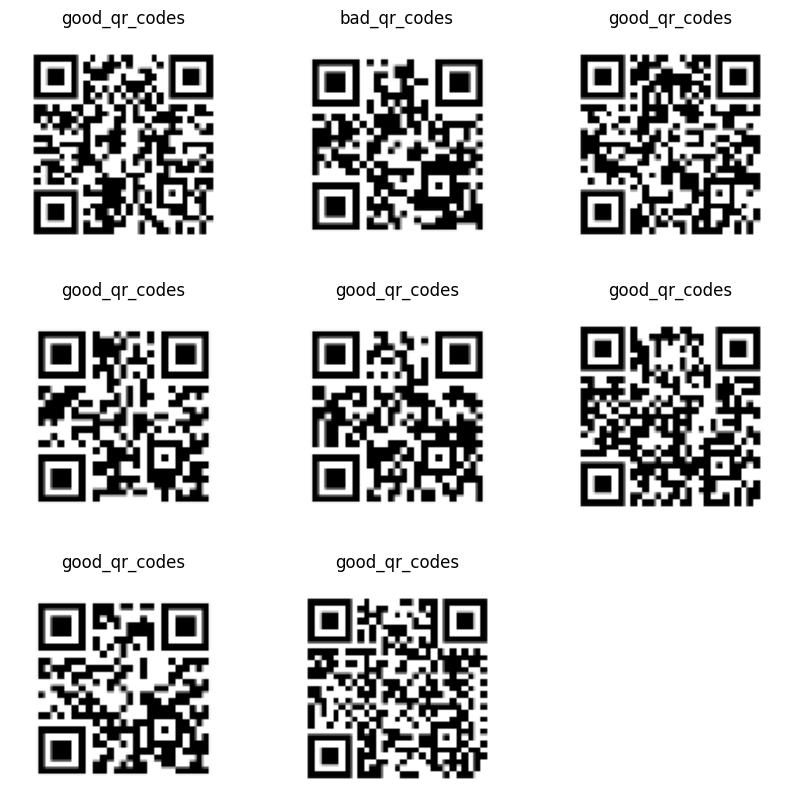

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in qr_train.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(qr_train.class_names[labels[i]])
    plt.axis("off")

In [6]:
# Show image sizes and other info (batch_size, height, width, color_channels)
for image_batch, labels_batch in qr_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 96, 96, 3)
(8,)


In [7]:
# Normalization / Scaling of colors
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [8]:
# Cache datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

qr_train = qr_train.cache().prefetch(buffer_size=AUTOTUNE)
qr_test = qr_test.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Create a model
num_classes = 2

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(img_width, img_height, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid', name="outputs")
])

# Compile (Adam)
model.compile(
  optimizer='adam',
  loss="binary_crossentropy",
  metrics=['accuracy'])

model.summary()

d:\Users\Lawson\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 858,209 (3.27 MB)

 Trainable params: 858,209 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(
  qr_train,
  epochs=3
)

Epoch 1/3
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 212s 42ms/step - accuracy: 0.7709 - loss: 1.8978
Epoch 2/3
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 193s 39ms/step - accuracy: 0.8102 - loss: 0.4390
Epoch 3/3
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 228s 46ms/step - accuracy: 0.8209 - loss: 0.4153


In [11]:
evaluation = model.evaluate(qr_test)
print("Accuracy of testing: {}".format(evaluation[1]))

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8163 - loss: 0.4166
Accuracy of testing: 0.8119999766349792
